In [25]:
import calendar

import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmocean
import numpy as np

In [2]:
ds = xr.open_dataset('/g/data/zv2/agcd/v1-0-1/tmax/mean/r005/01month/agcd_v1-0-1_tmax_mean_r005_monthly_2022.nc')

In [16]:
def plot_data(ds, month=5):
    """Plot a temperature data array"""

    fig = plt.figure(figsize=[15, 5])
    ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ds['tmax'].isel(time=month).plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.thermal,
        levels=np.arange(5, 35, 2.5),
        cbar_kwargs={'label': f'monthly average tmax (C)'},
    )
    ax1.coastlines()
    ax1.add_feature(cartopy.feature.STATES)
    plt.show()

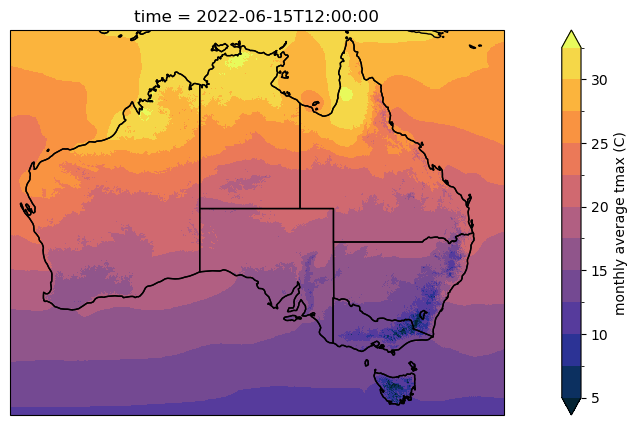

In [17]:
plot_data(ds)

In [5]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [6]:
states_gp['abbrev'] = ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT', 'OT']

In [7]:
states_gp

,STE_NAME21,AREASQKM21,LOCI_URI21,geometry,abbrev
0,New South Wales,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.06230 -31.50886, 159.06218...",NSW
1,Victoria,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341...",VIC
2,Queensland,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.53140 -10.68301, 142.53072...",QLD
3,South Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006...",SA
4,Western Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961...",WA
5,Tasmania,6.801754e+04,http://linked.data.gov.au/dataset/asgsed3/STE/6,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443...",TAS
6,Northern Territory,1.348134e+06,http://linked.data.gov.au/dataset/asgsed3/STE/7,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982...",NT
7,Australian Capital Territory,2.358133e+03,http://linked.data.gov.au/dataset/asgsed3/STE/8,"POLYGON ((149.06239 -35.15910, 149.09134 -35.1...",ACT
8,Other Territories,2.557420e+02,http://linked.data.gov.au/dataset/asgsed3/STE/9,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748...",OT


In [8]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="abbrev",
    name="states"
)

In [9]:
states_regions

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW              New South Wales
1 VIC                     Victoria
2 QLD                   Queensland
3  SA              South Australia
4  WA            Western Australia
5 TAS                     Tasmania
6  NT           Northern Territory
7 ACT Australian Capital Territory
8  OT            Other Territories

[9 regions]

## Simple 2D masks

regionmask requires that the spatial coords are called lat and lon

In [10]:
#mask2d = regionmask.mask_geopandas(states_gp, lons, lats)
mask2d = states_regions.mask(ds)

In [11]:
mask2d

<xarray.DataArray 'mask' (lat: 691, lon: 886)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 3kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 4kB 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
Attributes:
    standard_name:  region
    flag_values:    [0 1 2 3 4 5 6 7 8]
    flag_meanings:  NSW VIC QLD SA WA TAS NT ACT OT

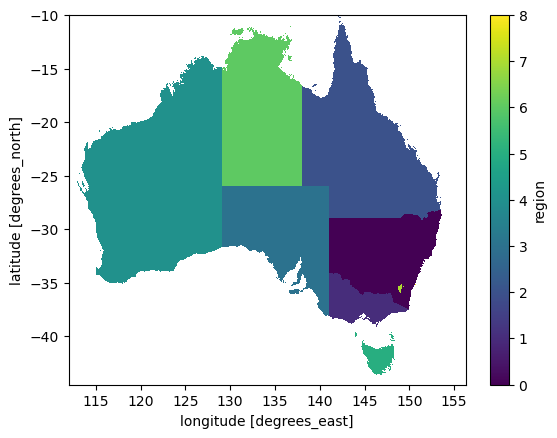

In [12]:
mask2d.plot()

In [13]:
mask2d.cf

Flag Variable:
       Flag Meanings:   NSW:     0 
                        VIC:     1 
                        QLD:     2 
                         SA:     3 
                         WA:     4 
                        TAS:     5 
                         NT:     6 
                        ACT:     7 
                         OT:     8 

Coordinates:
             CF Axes: * X: ['lon']
                      * Y: ['lat']
                        Z, T: n/a

      CF Coordinates: * longitude: ['lon']
                      * latitude: ['lat']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names: * latitude: ['lat']
                      * longitude: ['lon']

              Bounds:   n/a

       Grid Mappings:   n/a

In [50]:
#mask_QLD = mask2d.cf == "QLD"

### Select a region

In [18]:
ds_qld = ds.where(mask2d.cf == 'QLD')

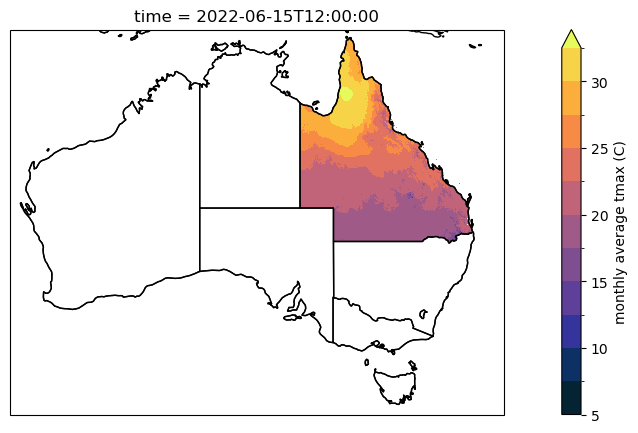

In [19]:
plot_data(ds_qld)

### Calculate weighted regional average

In [20]:
weights = np.cos(np.deg2rad(ds['lat']))
mean_tmax_qld = ds_qld['tmax'].weighted(weights).mean(dim=("lat", "lon"))

In [23]:
mean_tmax_qld

<xarray.DataArray 'tmax' (time: 12)> Size: 48B
array([36.065395, 34.401585, 35.039364, 31.500475, 26.193226, 23.29349 ,
       21.921665, 25.489431, 28.382887, 32.118156, 32.729813, 34.288315],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 96B 2022-01-16 ... 2022-12-16

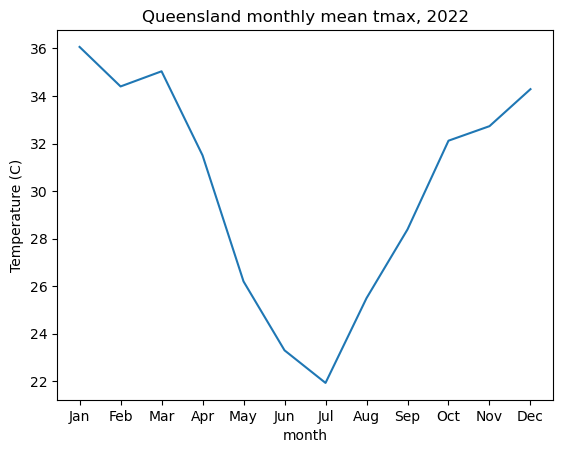

In [29]:
months = np.arange(1, 13)
plt.plot(months, mean_tmax_qld.values)
plt.ylabel("Temperature (C)")
plt.xlabel("month")
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
plt.title('Queensland monthly mean tmax, 2022')
plt.show()

### 3D masks

In [41]:
#mask3d = regionmask.mask_3D_geopandas(shapes, lons, lats)

In [21]:
mask3d

<xarray.DataArray 'mask' (region: 9, lat: 691, lon: 886)> Size: 6MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float32 3kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 4kB 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
  * region   (region) int64 72B 0 1 2 3 4 5 6 7 8
Attributes:
    standard_name:  region

In [23]:
type(mask)

xarray.core.dataarray.DataArray